In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
#import networkx as nx
import glob
import json
import matplotlib.pyplot as plt
import re
import gc

In [88]:
meta_df = pd.read_csv('./metadata.csv',usecols=["cord_uid", "sha", "title","abstract","publish_time","authors","journal","pdf_json_files","doi"])
meta_df.dropna(subset = ['abstract'],axis = 0, inplace = True)
meta_df.drop_duplicates(subset=['sha','title','abstract'],keep ='last',inplace=True)
meta_df.head()

/home/wenq/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,4,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cord_uid,sha,title,doi,abstract,publish_time,authors,journal,pdf_json_files
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,document_parses/pdf_json/d1aafb70c066a2068b027...
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,document_parses/pdf_json/6b0567729c2143a66d737...
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,Surfactant protein-D and pulmonary host defense,10.1186/rr19,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,document_parses/pdf_json/06ced00a5fc04215949aa...
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,Role of endothelin-1 in lung disease,10.1186/rr44,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,document_parses/pdf_json/348055649b6b8cf2b9a37...
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,Gene expression in epithelial cells in respons...,10.1186/rr61,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,document_parses/pdf_json/5f48792a5fa08bed9f560...


In [89]:
meta_df = meta_df.sample(10000, random_state=42)

In [90]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 77
languages = []
for i in tqdm(range(0,len(meta_df))):
    text = meta_df.iloc[i]['abstract'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        lang = "unknown"
    languages.append(lang)


100%|██████████| 10000/10000 [00:39<00:00, 251.75it/s]


In [91]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
print(languages_dict)

{'hr': 1, 'ro': 2, 'tr': 2, 'es': 41, 'en': 9834, 'it': 3, 'hu': 1, 'unknown': 1, 'zh-cn': 8, 'nl': 8, 'pt': 42, 'de': 28, 'fr': 26, 'ko': 3}


In [92]:
lang_df = pd.DataFrame(languages, columns=['lang'])
lang_df['is_en'] = np.where(lang_df['lang'] == 'en', 'en', 'other')
lang_df['count'] = lang_df.groupby('is_en')['is_en'].transform('count')

<BarContainer object of 2 artists>

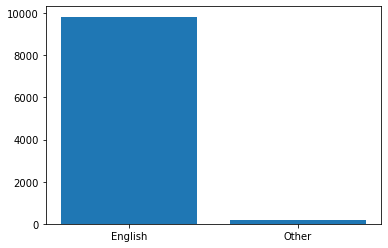

In [93]:
# sns.set_style("white")
# ax = sns.barplot(x="is_en",y = "count",data = lang_df, palette = "Set2")
# sns.despine()
# ax.get_figure().savefig("lang.png")
x = ['English', 'Other']
height = [lang_df['count'][0], 10000-lang_df['count'][0]]
plt.bar(x=x,height = height)
# , title = "English versus Non-English abstarcts distribution"

In [94]:
meta_df['language'] = languages
meta_df = meta_df[meta_df['language'] == 'en'] 
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9834 entries, 427575 to 395962
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cord_uid        9834 non-null   object
 1   sha             4046 non-null   object
 2   title           9833 non-null   object
 3   doi             6066 non-null   object
 4   abstract        9834 non-null   object
 5   publish_time    9828 non-null   object
 6   authors         9736 non-null   object
 7   journal         9110 non-null   object
 8   pdf_json_files  4046 non-null   object
 9   language        9834 non-null   object
dtypes: object(10)
memory usage: 845.1+ KB


In [109]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
meta_df['new_abstract'] = meta_df['abstract'].apply(lambda l:  l.strip().lower())
meta_df['abstract_no_sw'] = meta_df['new_abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
meta_df['tokenized_abstarct'] = meta_df['abstract_no_sw'].apply(word_tokenize)

[nltk_data] Downloading package stopwords to /home/wenq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wenq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [115]:
f=open('abstracts.txt','w')

count = 0

for ii in meta_df["tokenized_abstarct"]:
    f.write(' '.join(ii) + "\n")

f.close()

### LDA Analysis

In [13]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


In [25]:
cvec = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
X = cvec.fit_transform(meta_df.loc[:, 'abstract_no_sw'])
lda = LatentDirichletAllocation(n_components=100, max_iter=10, learning_method='online',verbose=False, random_state=42)
lda_df = lda.fit_transform(X)

In [79]:
meta_df["abstract"]

427575    Plant viruses are commonly vectored by flying ...
359165    The paper analyzes and comments on the results...
129191    We argue that the $q$-deformed spin-1 AKLT Ham...
344836    Warfarin therapy requires maintenance of a the...
165889    The American College of Cardiology and the Ame...
                                ...                        
422400    BACKGROUND: Since rotavirus is one of the lead...
416843    In a recently published study in this journal ...
347171    Coronavirus disease 2019 (COVID-19) is a virul...
105694    Accurate measurement of body composition is re...
395962    As the number of new enteroviruses and human p...
Name: abstract, Length: 9834, dtype: object

In [28]:
feature_names = cvec.get_feature_names()
n_top_words = 20
lda_topics = []
for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        lda_topics.append(top_features)

In [65]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:10]):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

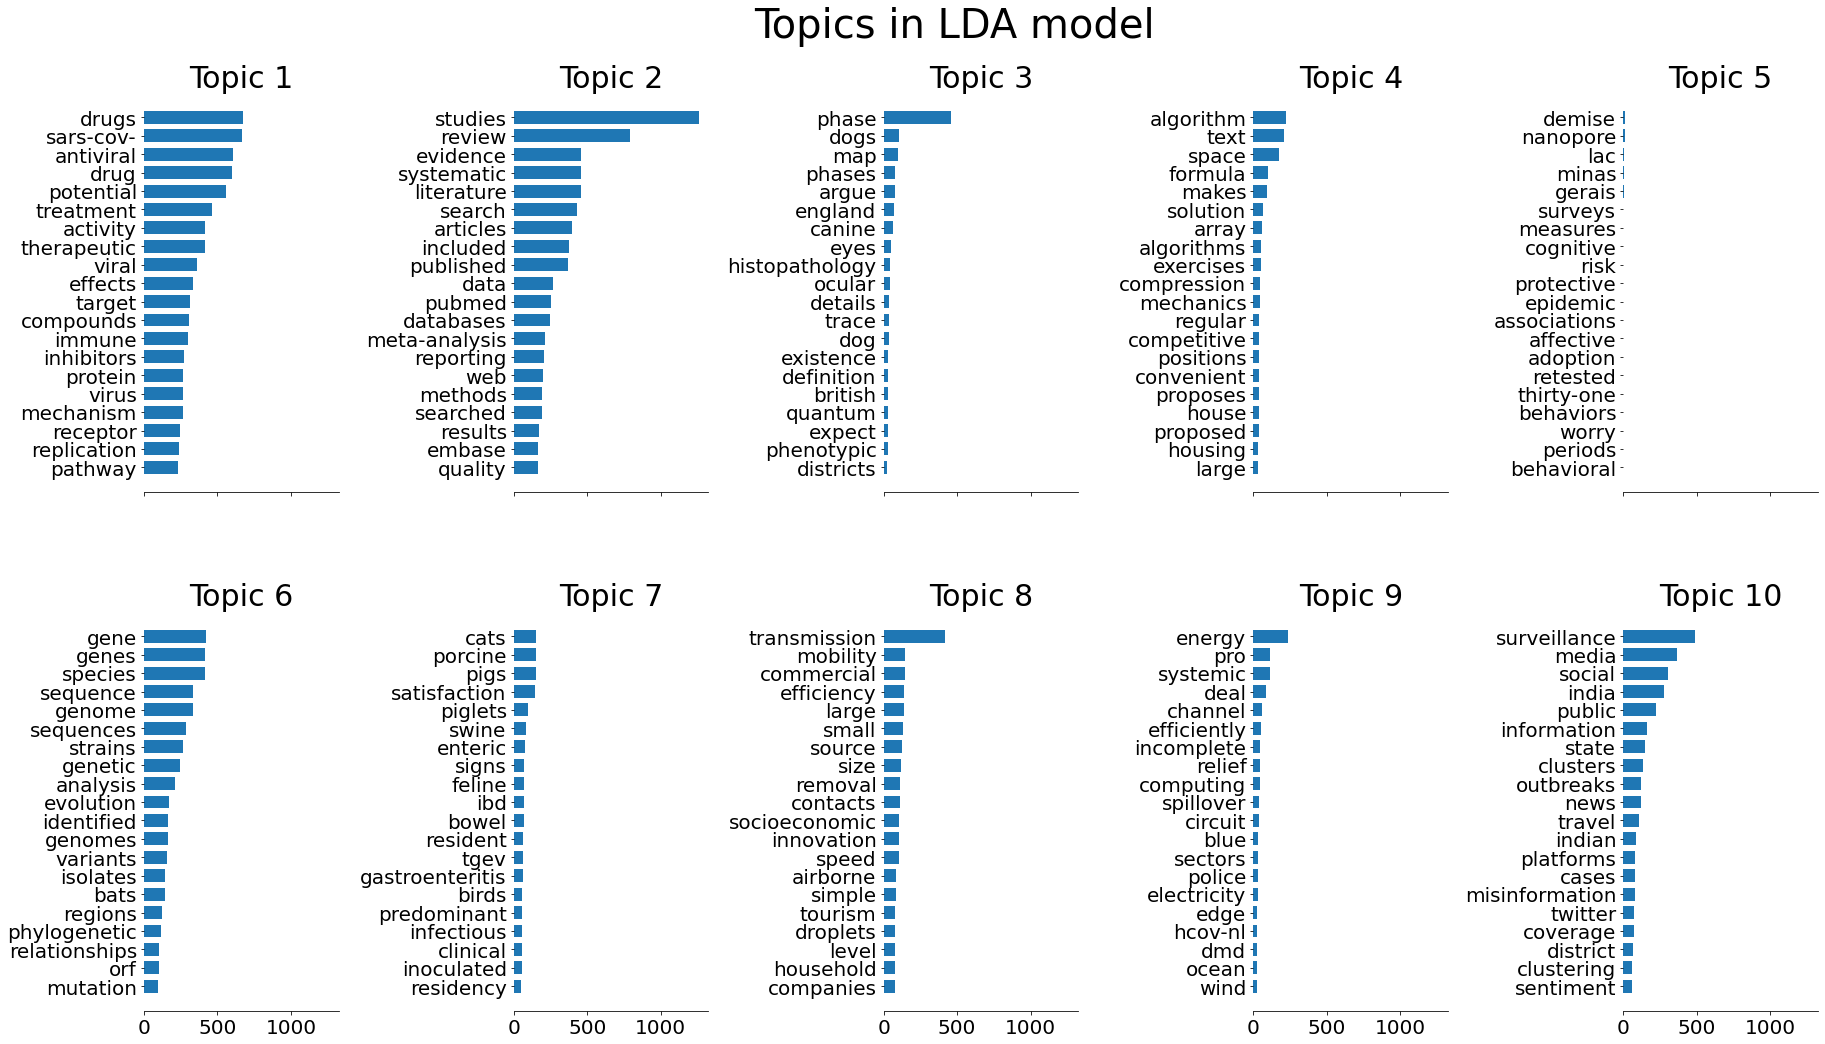

In [68]:
n_top_words = 20
feature_names = cvec.get_feature_names()
plot_top_words(lda, feature_names, n_top_words, 'Topics in LDA model')

## Compute Topic Coherence

Topic coherence
The state-of-the-art in terms of topic coherence are the intrinsic measure UMass and the extrinsic measure UCI, both based on the same high level idea. Both measure compute the sum
$$\text{Coherence} = \sum_{i \lt j} \text{score}(w_i, w_j)$$
of pairwise scores on the words $w_1, ..., w_n$ used to describe the topic, usually the top n words by frequency $p(w|k)$. This measure can be seen as the sum of all edges on complete graph.



Intrinsic UMass measure
The UMass measure introduced by [Mimno11a] uses as pairwise score function
$$\text{score}_{\text{UMass}}(w_i, w_j) =
    \log
    \frac{D(w_i, w_j) + 1}{D(w_i)}$$
which is the empirical conditional log-probability $\log p(w_j|w_i) = \log \frac{p(w_i, w_j)}{p(w_j)}$ smoothed by adding one to $D(w_i,w_j)$.

The score function is not symmetric as it is an increasing function of the empirical probability $p(w_j|w_i)$, where wi is more common than wj, words being ordered by decreasing frequency $p(w|k)$. So this score measures how much, within the words used to describe a topic, a common word is in average a good predictor for a less common word.

As the pairwise score used by the UMass measure is not symmetric, the order of the arguments matters. UMass measure is computing $p(rare word | common word)$, how much a common word triggers a rarer word. However, in human word association, high frequency words are more likely to be used as response words than low frequency words [Steyvers06]. It would be interesting to understand the effect of this choice by doing more experiments and comparing the two options.

In [100]:
f=open('bag_of_words.txt','w')

count = 0

for ii in feature_names:
        f.write(ii + " ")

f.close()

In [104]:
import gensim
from gensim import corpora
import os

topic_path = 'bag_of_words.txt'
with open(topic_path) as f:
    tokens = f.readlines()

# print(tokens)
covid_dic = corpora.Dictionary([[text for text in token.split()] for token in tokens])


In [119]:
path = 'abstracts.txt'
from gensim.utils import simple_preprocess
with open(path) as f:
    ldacorpus = f.readlines()
    
doc_tokenized = [simple_preprocess(doc) for doc in ldacorpus]
covid_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [120]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(topics=lda_topics, corpus = covid_corpus, dictionary=covid_dic, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-18.768062824707048


In [150]:
pca_topics = pp

In [151]:
## read in the pca_topics file as pca_topics
print(pca_topics)

[['occlusion', 'aneurysms', 'thrombectomy', 'stroke', 'days', 'ischemic', 'embolization', 'group', 'treatment', 'imaging', 'trial', 'aneurysm', 'ais', 'score', 'outcome', 'clot', 'dissection', 'carotid', 'device', 'analysis', 'posterior', 'mean', 'devices', 'artery', 'proximal', 'functional', 'risk', 'recanalization', 'stent', 'morbidity', 'technology', 'ischaemic', 'care', 'covid-', 'study', 'months', 'clinical', 'acute', 'coiling', 'favorable', 'series', 'research', 'retriever', 'rankin', 'cases', 'gov', 'circulation', 'documented', 'appears', 'examined', 'occlusions', 'potential'], ['study', 'laparoscopic', 'fluid', 'complications', 'surgical', 'pressure', 'hernia', 'renal', 'studies', 'pain', 'ablation', 'mesh', 'weight', 'bmi', 'group', 'disease', 'repair', 'treatment', 'respiratory', 'bariatric', 'severe', 'versus', 'shock', 'women', 'morphine', 'cost', 'acute', 'biopsy', 'atrial', 'left', 'units', 'resuscitation', 'fibrillation', 'coronary', 'lockdown', 'artery', 'centres', 'pro

In [162]:
cm2 = CoherenceModel(topics=pca_topics, corpus = covid_corpus, dictionary=covid_dic, coherence='u_mass')
coherence2 = cm2.get_coherence()
print(coherence2)

-18.57168277874653


|   | LDA | PCA+Clustering |
|---|-----|----------------|
|UMass| -18.768062824707048 | -18.57168277874653 |